In [102]:
### Wget and packages
!wget https://www.fit.vutbr.cz/study/courses/ISS/public/proj2021-22/signals/xtikho00.wav
import os, sys
import IPython
%matplotlib notebook
%matplotlib inline
from IPython.core.pylabtools import figsize
from google.colab import files
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt 
from scipy import stats
from scipy import signal as sig
from scipy.fft import fftshift
import scipy.io.wavfile
import matplotlib.backends.backend_pdf as pdf
from matplotlib.transforms import Bbox

In [103]:
### Set of functions

## Essentials

# Single signal plot function
def plot_single_signal ( signal = None, xSize = 10, ySize = 5, sRate = 16000, 
                        plotLabel = 'Label', xLabel = 'Time [s]', DFT = 'no',
                        color = 'b' ) :

  _, ax = plt.subplots( figsize = (xSize, ySize) )
  end = sRate

  if xLabel == 'Time [s]':
    end = len(signal) / sRate
  else:
    xLabel = 'Frequency [Hz]'

  timeSteps = np.linspace( 0, end, len(signal) )
  
  if DFT == 'yes':
    ax.set( xlim = (0 - 0.01 * end, 0.51 * end), 
           ylim = (1.1 * np.min(signal), 1.1 * np.max(signal)), 
           xlabel = xLabel, title = plotLabel )
  else:
    ax.set( xlim = (0 - 0.01 * end, 1.01 * end), 
           ylim = (1.1 * np.min(signal), 1.1 * np.max(signal)), 
           xlabel = xLabel, title = plotLabel )
    
  ax.plot( timeSteps, signal, label = plotLabel, color = color )

# Spectrogram plot
def plot_spectrogram ( t = None, f = None, spectre = None, xSize = 10, ySize = 10 ) :

  plt.figure(figsize = (xSize, ySize))
  plt.pcolormesh(t, f, spectre )
  plt.gca().set( xlabel = 'Time [s]', ylabel = 'Frequency [Hz]' )

# Function for proper plots saving
def full_extent ( ax, pad = 0.0 ) :
  
  ax.figure.canvas.draw()
  items = ax.get_xticklabels() + ax.get_yticklabels()
  items += [ax, ax.title]
  bbox = Bbox.union([item.get_window_extent() for item in items])

  return bbox.expanded(1.0 + pad, 1.0 + pad)


# ------------------------------------------------------------------------------

## 4.1 Basics

def do_basic_stuff ( file = None ) :

  signal, sRate = sf.read( file )

  signalLength = len(signal)
  signalDuration = signalLength / sRate

  print( "Signal duration [] = " + str(len(signal)) + ";", 
        "Signal duration [s] = " + str(signalDuration) + ";", 
        "\nMinimum value = " + str(signal.min()) + ";", 
        "Maximum value = " + str(signal.max()) + ";", 
        "\nMean value = " + str(signal.mean()) + "." )
  
  return signal, sRate

# ------------------------------------------------------------------------------

## 4.2 Pre-processing and framing

# Signal pre-processing
def normalize_signal ( signal = None ) : 
  
  # Subtract mean signal value and normalize
  signal = signal - signal.mean()
  signal = signal / np.abs(signal).max()

  return signal

# Signal framing
def frame_signal ( signal = None, frameLength = 1024, overlapLength = 512, plotGraph = 'Yes' ) :

  signalLength = len(signal)
  stepLength = frameLength - overlapLength

  numberOfFrames = np.abs(signalLength - overlapLength) // np.abs(frameLength - overlapLength) + 1
  restLength = np.abs(signalLength - overlapLength) % np.abs(frameLength - overlapLength)
  
  addedZeroSignalLength = stepLength - restLength
  addedZeroSignal = np.zeros(addedZeroSignalLength)
  signal = np.append(signal, addedZeroSignal)

  index1 = np.tile(np.arange(0, frameLength), (numberOfFrames, 1))
  index2 = np.tile(np.arange(0, numberOfFrames * stepLength, stepLength), (frameLength, 1)).T
  indices = index1 + index2
  if plotGraph == 'Yes':
    plot_single_signal( signal, xSize = 20, ySize = 5, 
                       plotLabel = 'New signal (still noisy but now normalized and divisible w/o reminder by 1024)', 
                       color = 'g' )

  return signal[indices.astype(np.int32, copy=False)]
  

# ------------------------------------------------------------------------------

## 4.3 Discrete Fourier Transform

# My discrete fourier transform
def myDFT ( signal = None, numberOfSamples = 1024 ) :

  # generate matrix
  serieDeFourier = np.fromfunction( lambda n, k : np.exp(-1j * 2 * np.pi * n * k / (numberOfSamples)), 
                         (numberOfSamples , numberOfSamples), 
                         dtype = "complex128" )
  
  # dot product
  return np.dot(serieDeFourier, signal)

# ------------------------------------------------------------------------------

## 4.4 Spectrogram

# Info for spectrogram plot
def spectrogram ( signal = None, frameLength = 1024, overlapLength = 512, sRate = 16000 ) : 

  frames = frame_signal( signal, plotGraph = 'No' )
  dftCoefficients = np.array(list(map( np.fft.fft, frames )))
  
  dftCoefficients = dftCoefficients.T
  dftCoefficients = dftCoefficients[:len(dftCoefficients) // 2]

  spectreCoefficients = 20 * np.log10(np.abs(dftCoefficients))
  t = np.linspace(0, len(signal)/sRate, spectreCoefficients.shape[1])
  f = np.linspace(0, 8000, spectreCoefficients.shape[0])

  return t, f, spectreCoefficients

# ------------------------------------------------------------------------------

## 4.5 Find interference frequencies

def find_bad_frequencies ( signal = None, sRate = 16000 ) :
  
  _, _, spectre = spectrogram( signal )

  maxs = spectre.max(axis = 1)
  mins = spectre.min(axis = 1)
  differences = maxs - mins
  bad_indeces = differences.argsort()[:8]  
  # [192 144 96 191 193 145 48 196] not great; -> try other method              

  # first frame contains nothing but cosine noise
  frames = frame_signal( signal, plotGraph = 'No' )
  dftCoefficients = np.abs(np.fft.fft( frames[0] ))

  plot_single_signal( dftCoefficients, xSize = 20, ySize = 5, plotLabel = 'First frame', 
                     xLabel = 'Frequency [Hz]', DFT = 'yes', color = 'g' )
  
  dftCoefficients = dftCoefficients[:len(dftCoefficients)//2]
  badIndeces = np.argpartition(dftCoefficients, -4)[-4:]
  # Sort by value
  badIndeces[0], badIndeces[1], badIndeces[2], badIndeces[3] = \
  badIndeces[1], badIndeces[2], badIndeces[3], badIndeces[0]
  
  return badIndeces * 16000 // 1024

# ------------------------------------------------------------------------------

## 4.6 Signal generation

def generate_4_cosines ( signal = None, frequencies = None, sRate = 16000 ) :

  t = np.arange(len(signal)) / sRate

  cos1 = np.cos(2 * np.pi * frequencies[0] * t)
  cos2 = np.cos(2 * np.pi * frequencies[1] * t)
  cos3 = np.cos(2 * np.pi * frequencies[2] * t)
  cos4 = np.cos(2 * np.pi * frequencies[3] * t)

  return cos1 + cos2 + cos3 + cos4

# ------------------------------------------------------------------------------

## 4.7 - 4.10 Filter 

def filter_signal ( signal = None, frequencies = None,  sRate = 16000, analyzeFilter = 'Yes' ) :
  
  a = np.empty([4, 9])
  b = np.empty([4, 9])

  # Filter creation and application (4.7 and 4.10)
  for i in range(len(frequencies)):

    Wp = np.array([frequencies[i] - 65, frequencies[i] + 65]) * 2 / sRate
    Ws = np.array([frequencies[i] - 15, frequencies[i] + 15]) * 2 / sRate
    n, wNorm = sig.buttord( Wp, Ws, 3, 40 )
    b[i], a[i] = sig.butter( n, wNorm, btype = 'bandstop' )
    signal = scipy.signal.lfilter( b[i], a[i], signal )

  # Filter analysis (4.7, 4.8 and 4.9)
  if analyzeFilter == 'Yes':
    
    # Impulse response
    N = 32
    impulse = [1, *np.zeros(N - 1)]
    f, axs = plt.subplots( 4, 1, figsize = (5, 12) )
    f.tight_layout()
    for n, b1, a1 in zip(range(len(frequencies)), b, a):

      h = scipy.signal.lfilter(b1, a1, impulse)
      axs[n].stem( np.arange(N), h )
      axs[n].grid( alpha = 0.5, linestyle = '--' )
      axs[n].title.set_text( str(frequencies[n]) + ' Hz filter\'s impulse response' )
      plt.tight_layout()
      extent = full_extent(axs[n]).transformed(f.dpi_scale_trans.inverted())
      
    # Zeros and poles
    f, axs = plt.subplots( 4, 1, figsize = (4, 16) )
    ang = np.linspace(0, 2 * np.pi, 100)
    for n, b2, a2 in zip(range(len(frequencies)), b, a):

      z, p, k = scipy.signal.tf2zpk( b2, a2 )
      axs[n].plot( np.cos(ang), np.sin(ang) )
      
      axs[n].scatter( np.real(z), np.imag(z), marker = 'o', facecolors = 'none', edgecolors = 'r', label = 'zeros' )
      axs[n].scatter( np.real(p), np.imag(p), marker = 'x', color = 'g', label = 'poles' )

      axs[n].title.set_text( str(frequencies[n]) + ' Hz filter\'s poles and zeros' )
      axs[n].grid( alpha = 0.5, linestyle = '--' )
      axs[n].legend( loc = 'upper left' )
      plt.tight_layout()

      extent = full_extent(axs[n]).transformed(f.dpi_scale_trans.inverted())
      #plt.savefig( "poles_n_zeros" + str(n + 1) + ".pdf", bbox_inches = extent )

      # Stability 
      is_stable = (p.size == 0) or np.all(np.abs(p) < 1) 
      print("Stable? -", is_stable)

    # Frequency characteristics
    for n, b3, a3 in zip(range(len(frequencies)), b, a):

      w, h = sig.freqz( b3, a3 )
      fig, ax = plt.subplots(1, 2, figsize=(10,3))

      ax[0].plot(w / 2 / np.pi * sRate, np.abs(h))
      ax[0].set(xlabel = 'Frequency [Hz]')
      ax[0].title.set_text( str(frequencies[n]) + ' Hz filter\'s frequency characteristics\' absolute value' )

      ax[1].plot(w / 2 / np.pi * sRate, np.angle(h))
      ax[1].set(xlabel = 'Frekuence [Hz]')
      ax[1].set_title( str(frequencies[n]) + ' Hz filter\'s frequency characteristics\' argument' )

      fig.tight_layout()

  return signal

Signal duration [] = 52532; Signal duration [s] = 3.28325; 
Minimum value = -0.1983642578125; Maximum value = 0.23193359375; 
Mean value = -2.5046350096726756e-05.


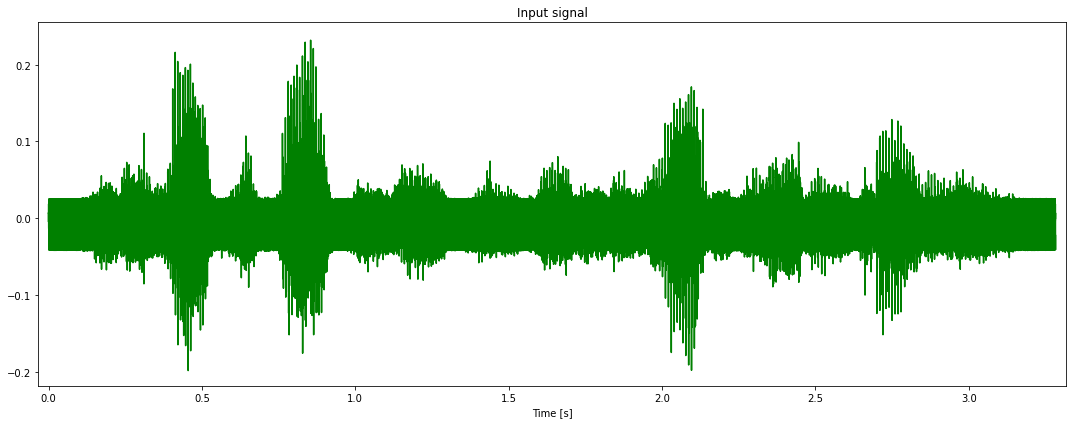

In [104]:
## 4.1 Basics

signal, sRate = do_basic_stuff( 'xtikho00.wav' )
plot_single_signal( signal, xSize = 15, ySize = 6, plotLabel = 'Input signal', color = 'g' )
plt.tight_layout()

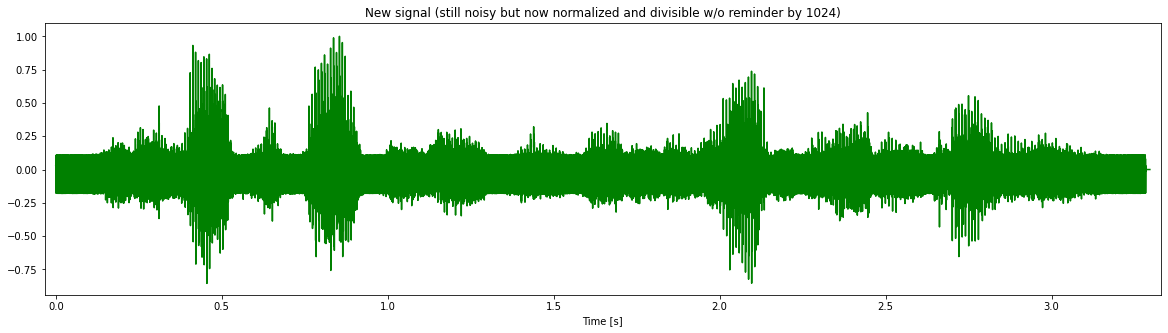

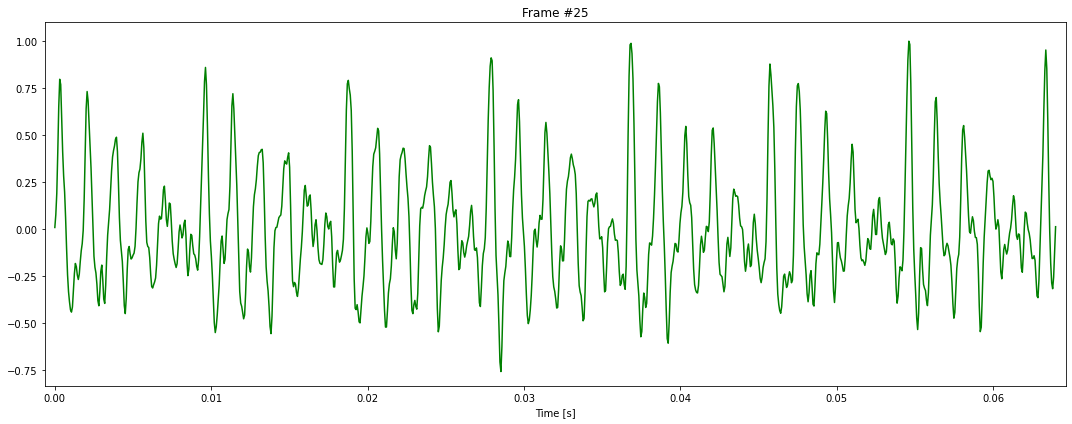

In [105]:
## 4.2 Pre-processing and frames

normalizedSignal = normalize_signal( signal )
framesOfSignal = frame_signal( normalizedSignal, plotGraph = 'Yes' )

# 25th frame is the best one of them all
bestFrame = framesOfSignal[25]
plot_single_signal( bestFrame, xSize = 15, ySize = 6, plotLabel = 'Frame #25', color = 'g' )
plt.tight_layout()

True


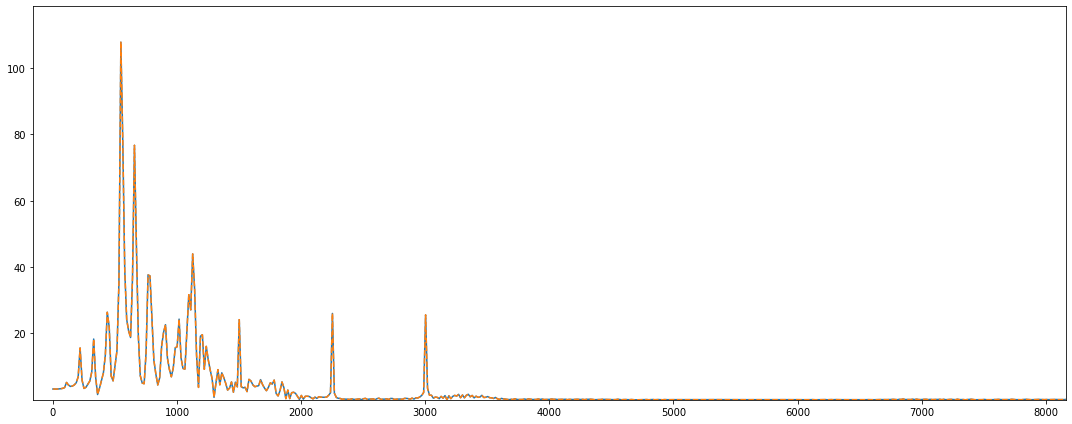

In [106]:
## 4.3 Discrete Fourier Transform

myDftCoefficients = np.abs(myDFT( bestFrame ))
npDftCoefficients = np.abs(np.fft.fft( bestFrame ))

# Same as np.dft.dft -> true
print( np.allclose(myDftCoefficients, npDftCoefficients) )

timeSteps = np.linspace( 0, 16000, len(npDftCoefficients) )
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot( timeSteps, myDftCoefficients )
ax.plot( timeSteps, npDftCoefficients, linestyle = '--' )
ax.set( xlim = (0 - 0.01 * 16000, 0.51 * 16000), ylim = (1.1 * np.min(npDftCoefficients), 1.1 * np.max(npDftCoefficients)))
plt.tight_layout()

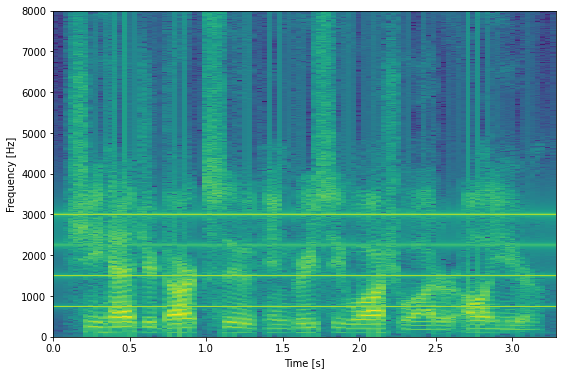

In [107]:
## 4.4 Spectrogram

t, f, spectreCoefficients = spectrogram( normalizedSignal )
plot_spectrogram( t, f, spectreCoefficients, xSize = 9, ySize = 6 )

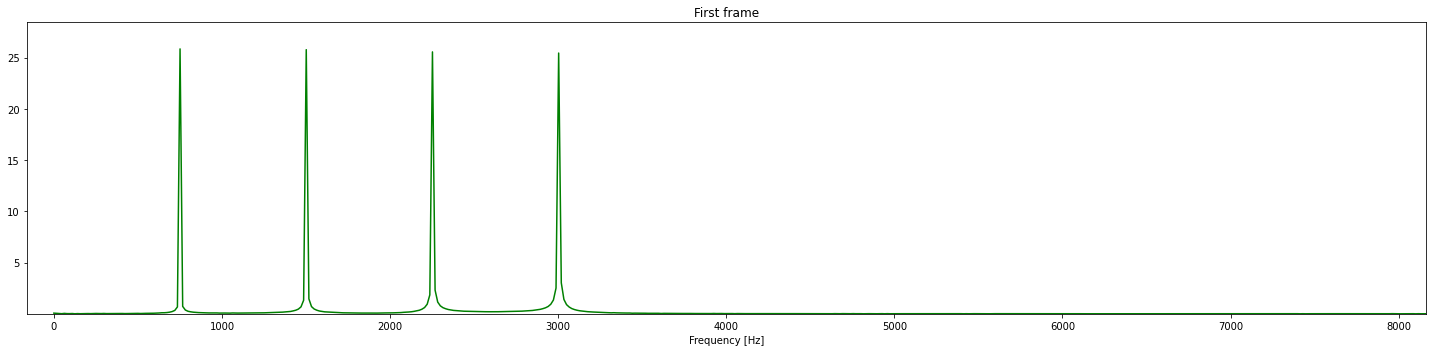

In [108]:
## 4.5 Interference frequencies

badFrequencies = find_bad_frequencies( normalizedSignal )
plt.tight_layout()

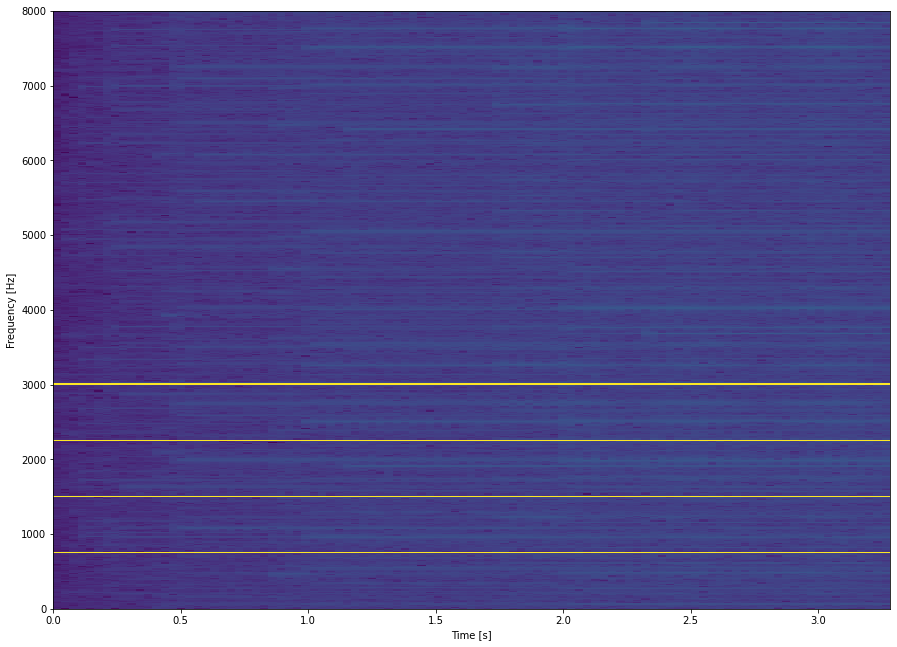

In [109]:
## 4.6 Signal generation

cosineSignal = generate_4_cosines( normalizedSignal, badFrequencies )

t, f, spectreCoefficients = spectrogram( cosineSignal )

plot_spectrogram( t, f, spectreCoefficients, xSize = 15, ySize = 11 )

IPython.display.display(IPython.display.Audio( cosineSignal, rate = sRate ))
# download button is only available from 2nd player (idk why) 
IPython.display.display(IPython.display.Audio( cosineSignal, rate = sRate ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:211: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warni

Stable? - True
Stable? - True
Stable? - True
Stable? - True


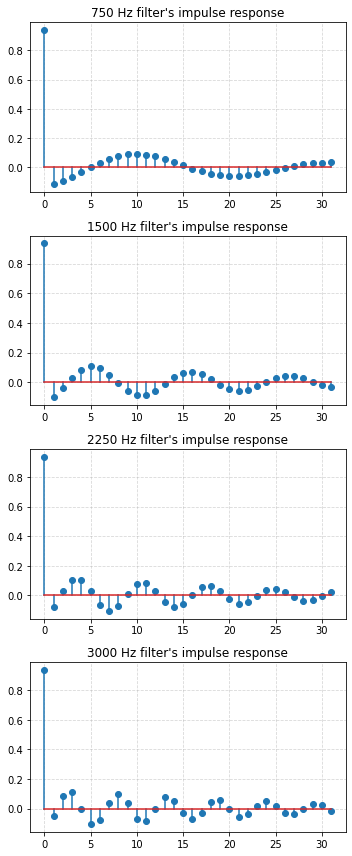

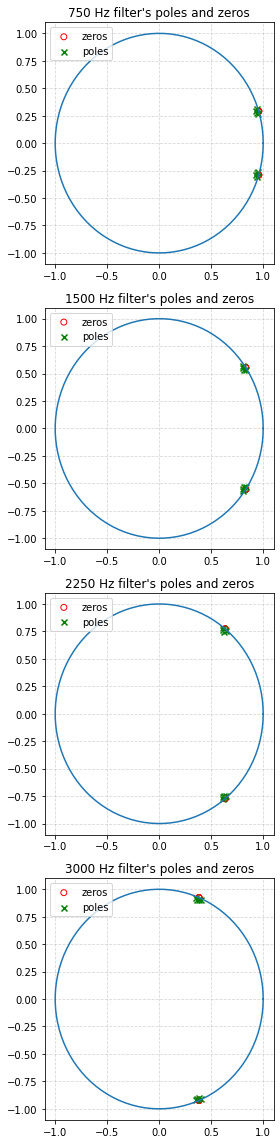

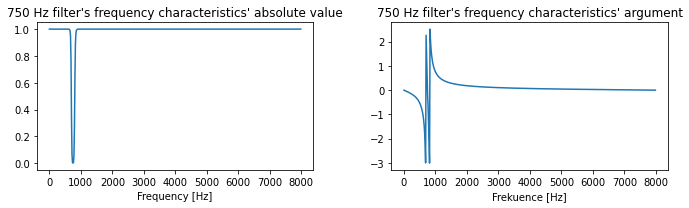

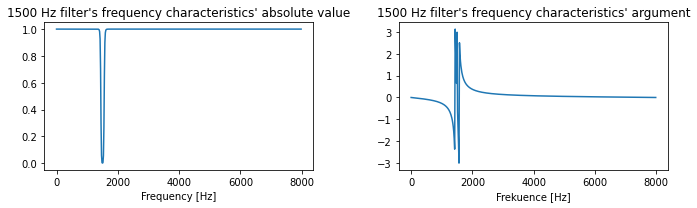

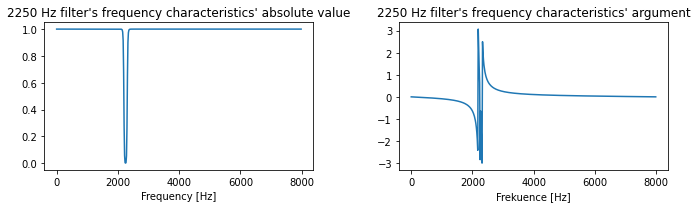

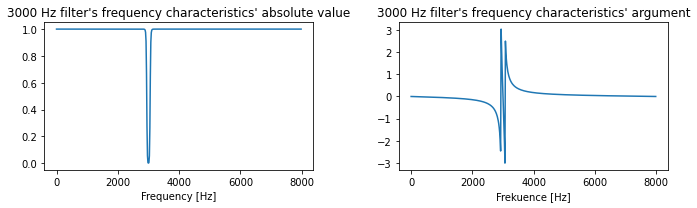

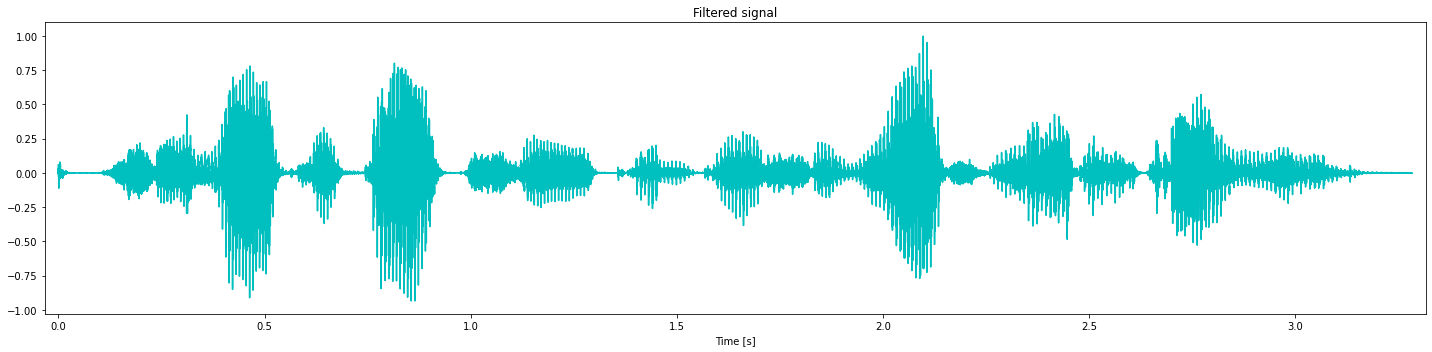

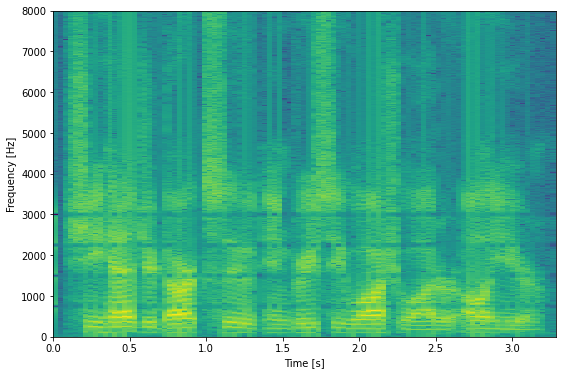

In [110]:
## 4.7 - 4.10 Filter

filteredSignal = filter_signal( normalizedSignal, badFrequencies, analyzeFilter = 'Yes' )
normalizedFilteredSignal = normalize_signal( filteredSignal )

plot_single_signal( normalizedFilteredSignal, xSize = 20, ySize = 5, plotLabel = 'Filtered signal', color = 'c' )
plt.tight_layout()

t, f, spectre = spectrogram( normalizedFilteredSignal )
plot_spectrogram( t, f, spectre, xSize = 9, ySize = 6 )
# Noisy one
IPython.display.display(IPython.display.Audio( normalizedSignal, rate = sRate ))
# Filtered one
IPython.display.display(IPython.display.Audio( normalizedFilteredSignal, rate = sRate ))